In [62]:
import numpy as np
import os
import wfdb
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

gait_dataset_path = 'E:/database/gait-in-neurodegenerative-disease-database-1.0.0'
gait_filenames = [
    f'{gait_dataset_path}\\{name}'
    for name in sorted(set(el.split('.')[0] for el in os.listdir(gait_dataset_path) if el.endswith('.hea')))
]
gait_data, gait_labels = [], []
for filename in gait_filenames:
    ar, meta = wfdb.rdsamp(filename)
    gait_data.append(ar)
    label = filename.split('\\')[-1]
    for i in range(len(label)):
        if label[i].isnumeric():
            label = label[:i]
            break
    gait_labels.append(label)
gait_data = np.stack(gait_data)[:, 20*300:]
gait_labels = label_encoder.fit_transform(gait_labels)

In [64]:
import numpy as np
from scipy.spatial import distance_matrix
from tqdm import tqdm

def get_weights(pts, exp=1):
    n_pts = len(pts)
    A = np.exp(-distance_matrix(pts, pts))
    b = np.ones(n_pts)
    w = np.linalg.lstsq(A, b, rcond=None)[0]
    return w.reshape(-1, 1)

def signals_to_curves(signals, dim=5, stride=2):
    # last dimension = channels
    if isinstance(signals, np.ndarray):
        size = signals.shape[-2]
        result = np.concatenate([signals[..., i*stride:size-(dim-i-1)*stride, :] for i in range(dim)], axis=-1)
        return result
    elif isinstance(signals, list):
        return [signals_to_curves(signal, dim, stride) for signal in signals]
    else:
        raise ValueError

def weights_from_pclouds(pclouds, exp=0):
    if exp == 0:
        return [np.ones((pcloud.shape[0], 1)) / pcloud.shape[0] 
                for pcloud in tqdm(pclouds, total=len(pclouds), desc='weight computation', miniters=100)]
    else:
        return [get_weights(pcloud, exp) 
                for pcloud in tqdm(pclouds, total=len(pclouds), desc='weight computation', miniters=100)]

In [90]:
rng = np.random.default_rng(42)
# test_mask = np.full_like(gait_labels, False, dtype='bool')
# for i in range(4):
#     for idx in rng.choice(np.where(gait_labels == i)[0], np.sum(gait_labels == i) // 5):
#         test_mask[idx] = True

sig_len = 84000
seg_len = 500
gait_data_cut = gait_data.reshape(-1, seg_len, 2)
gait_labels_cut = np.tile(gait_labels.reshape(-1, 1), (1, sig_len//seg_len)).ravel()
# test_mask_cut = np.tile(test_mask.reshape(-1, 1), (1, sig_len//seg_len)).ravel()
test_mask = np.zeros((gait_data.shape[0], sig_len//seg_len), dtype=np.int32)
test_mask[:, int(0.8*test_mask.shape[1]):] = 1
test_mask_cut = test_mask.ravel().astype(bool)

mask_notna = ~np.isnan(gait_data_cut).any(axis=(1,2))
gait_data_cut, gait_labels_cut = gait_data_cut[mask_notna], gait_labels_cut[mask_notna]
test_mask_cut = test_mask_cut[mask_notna]

In [68]:
pclouds = signals_to_curves(gait_data_cut, 3, 20)
weights = weights_from_pclouds(pclouds, 1.)
weights_unif = weights_from_pclouds(pclouds, 0)
# embedded = embedding_pclouds(pclouds, weights)
# embedded_unif = embedding_pclouds(pclouds, weights_unif)

weight computation: 100%|████████████████████████████████████████████████████| 10583/10583 [00:00<00:00, 220961.63it/s]


In [184]:
import tensorflow as tf
from tensorflow import keras

class MyLayer(keras.layers.Layer):
    def __init__(self, dim, n_filters=20):
        super(MyLayer, self).__init__()
        self.forward = keras.Sequential([
            keras.layers.Dense(
                units=64,
                activation='elu'
            ),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(
                units=64,
                activation='elu'
            ),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(
                units=64,
                activation='elu'
            ),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(
                units=n_filters
            ),
        ])
        
    def call(self, inputs, *args, **kwargs):
        pclouds, weights = inputs
        filtered = self.forward(pclouds)
        features = tf.math.reduce_sum(filtered * weights, axis=1)
        return features
    
# X1 = tf.ragged.constant(pclouds, ragged_rank=1, inner_shape=(6, ))
# X2 = tf.ragged.constant(weights, ragged_rank=1, inner_shape=(1, ))
# X_train = [tf.ragged.boolean_mask(X1, ~test_mask_cut), tf.ragged.boolean_mask(X2, ~test_mask_cut)]
# X_test = [tf.ragged.boolean_mask(X1, test_mask_cut), tf.ragged.boolean_mask(X2, test_mask_cut)]
X_train = [np.stack(pclouds)[~test_mask_cut], np.stack(weights)[~test_mask_cut]]
X_test = [np.stack(pclouds)[test_mask_cut], np.stack(weights)[test_mask_cut]]
y_train, y_test = gait_labels_cut[~test_mask_cut], gait_labels_cut[test_mask_cut]

In [185]:
from sklearn.decomposition import PCA

my_layer = MyLayer(dim=6, n_filters=32)
tmp = my_layer(X_train).numpy()

pca = PCA()
pca.fit(tmp)

PCA()

In [186]:
np.cumsum(pca.explained_variance_ratio_) * 100

array([74.8764  , 91.713524, 98.67934 , 99.40631 , 99.70205 , 99.81928 ,
       99.881165, 99.92934 , 99.95198 , 99.96991 , 99.976425, 99.98284 ,
       99.987404, 99.9901  , 99.9923  , 99.993935, 99.995255, 99.99641 ,
       99.997406, 99.99811 , 99.99851 , 99.99887 , 99.99917 , 99.99936 ,
       99.99953 , 99.99966 , 99.99976 , 99.99983 , 99.99991 , 99.99995 ,
       99.99998 , 99.999985], dtype=float32)

In [177]:
keras.backend.clear_session()
tf.random.set_seed(42)

inputs_p = keras.Input(shape=(460, 6))
inputs_w = keras.Input(shape=(460, 1))
inputs = [inputs_p, inputs_w]
my_layer = MyLayer(dim=6, n_filters=32)
features = my_layer(inputs)
outputs = features
outputs = keras.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units=4,
        activation='softmax'
    )
])(outputs)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(5e-2),
    metrics=['accuracy']
)
model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=1 << 10,
)
model.evaluate(X_test, y_test)

Epoch 1/5
9/9 [==============================] - 4s 349ms/step - loss: 1.3859 - accuracy: 0.4047
Epoch 2/5
9/9 [==============================] - 3s 348ms/step - loss: 1.0937 - accuracy: 0.4944
Epoch 3/5
9/9 [==============================] - 3s 346ms/step - loss: 0.9713 - accuracy: 0.5167
Epoch 4/5
9/9 [==============================] - 3s 357ms/step - loss: 0.9201 - accuracy: 0.5799
Epoch 5/5
67/67 [==============================] - 0s 3ms/step - loss: 3.1970 - accuracy: 0.2583


[3.197028875350952, 0.258321613073349]

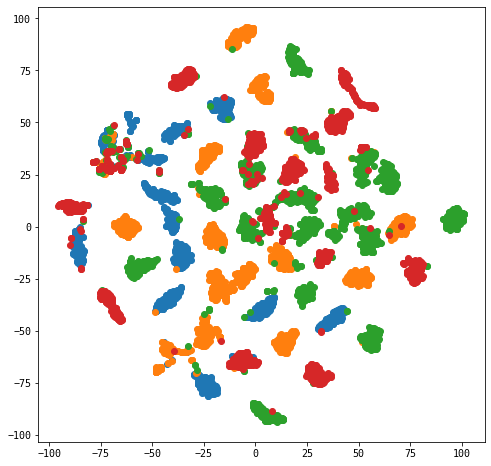

In [199]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_train)
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.scatter(*X_tsne[y_train==i].T)
plt.show(); plt.close();

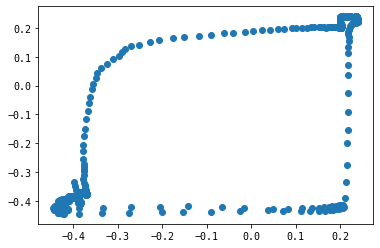

In [174]:
idx = 1000
plt.scatter(gait_data_cut[idx, 20:, 0], gait_data_cut[idx, :-20, 0])